In [15]:
%load_ext autoreload
%autoreload 2

import torch
import pyro
from pyro import distributions as dist
from pyro import poutine
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
from model import YModel

import matplotlib.pyplot as plt
%matplotlib inline

#device = torch.device("cuda", 0)
device = torch.device("cpu")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
my_cmap = plt.cm.jet
my_cmap.set_under('white')



# Model

## Toy model

Input X - corresponds to any kind of phase space input - some **distribution** with prior.
Input $\mu$ - corresponds to parameters of surrogate, ie - size of detector, magnetic field, etc. - a **number**.

Define some functions f, g - those can be varied. Probably, bettern to stick with some types of them, ie:
continous, pereodic, polynomial, ...


$$X \sim U(x_{min}, x_{max}), \ \ \mu \sim \delta(\mu - \mu_0) $$

$$latent\_x \sim  \mathcal{N} (latent\_x | X, 1)$$


$$ f(\alpha) = a + b \alpha  $$
$$ g(\alpha) = d * \alpha $$

$$y \sim \mathcal{N}(y|f(latent\_x) + g(\mu), 1)$$

### Problem statement

1. Fit GAN/GP/NV to match p(y|X,mu)

2. Solve optimisaiton problem of the choise:
 - $argmin_{mu} (y - Y_0) ^2 $
 - $argmax_{mu} p(y|mu) = \int p(y|X,mu) p(X) dx$
 - $etc$



## Make model with `pyro`


## Investigation of the model

In [2]:
y_sampler = YModel(init_mu=torch.tensor([0., 0.]))

In [3]:
mu_dim = 2
x_dim = 1
mu_range = (-10, 10)
n_samples = 10000
noise_size = 1000

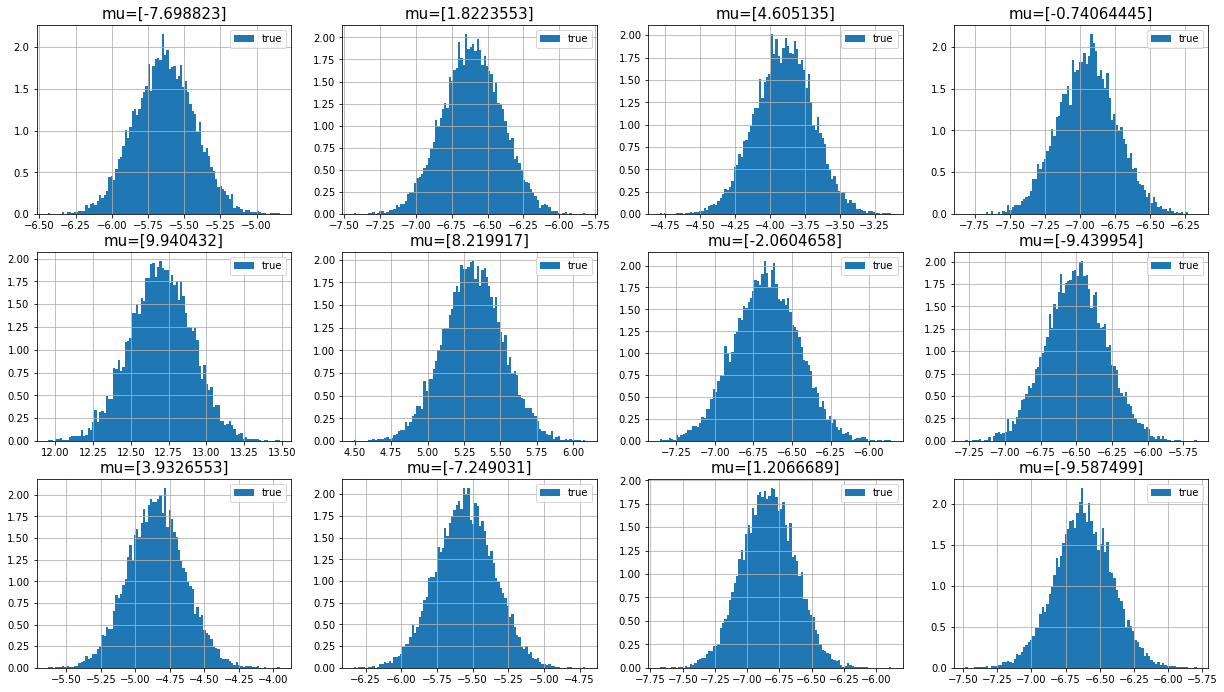

In [4]:
plt.figure(figsize=(21,16))
mu = dist.Uniform(*mu_range).sample([12, mu_dim])
for index in range(12):
    plt.subplot(4, 4, index + 1)

    mu_s = mu[index, :].repeat(n_samples, 1)
    x_s = y_sampler.x_dist.sample([len(mu_s), noise_size])
    y_sampler.make_condition_sample({'mu': mu_s, 'X':x_s})

    plt.hist(y_sampler.condition_sample().mean(dim=1).cpu().numpy(), bins=100, density=True, label='true');
    plt.grid()
    plt.legend()
    plt.title("mu={}".format(mu[index, :].cpu().numpy()), fontsize=15);

CPU times: user 924 ms, sys: 4 ms, total: 928 ms
Wall time: 943 ms


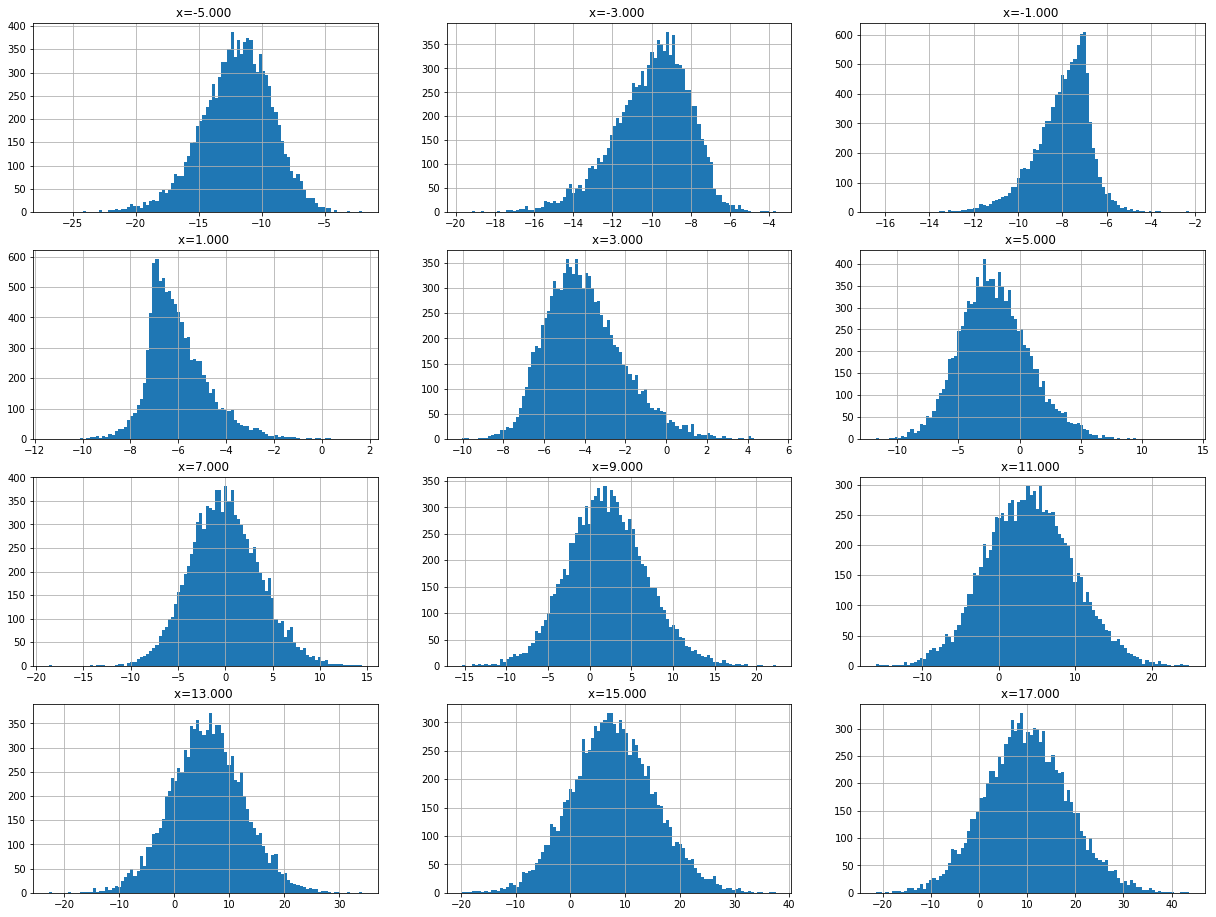

In [8]:
%%time
plt.figure(figsize=(21,16))
x_r = list(range(-5, 18, 2))
for i in range(4):
    for j in range(3):
        plt.subplot(4,3, i*3 + j + 1)
        y_sampler.make_condition_sample({'X': torch.tensor([float(x_r[i*3 + j])] * 10000).reshape(-1,1)})
        plt.hist(y_sampler.condition_sample().detach().numpy(), bins=100);
        plt.grid()
        #plt.legend()
        plt.title("x={:.3f} ".format(x_r[i*3 + j]))

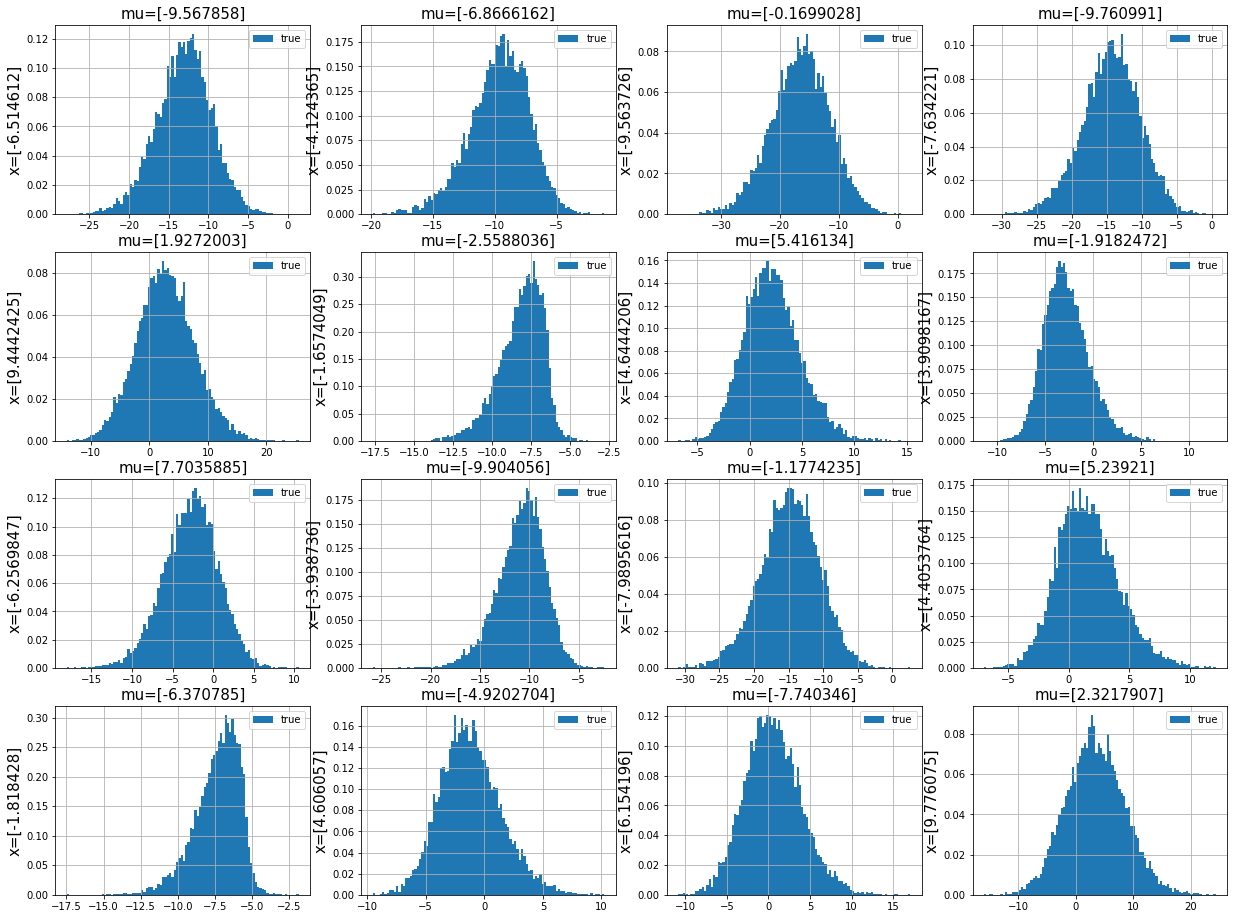

In [21]:
plt.figure(figsize=(21,16))

mu = dist.Uniform(*mu_range).sample([16, mu_dim])
x = y_sampler.x_dist.sample([16, x_dim])

for index in range(16):
    plt.subplot(4, 4, index + 1)
    mu_s = mu[index, :].repeat(10000, 1)
    x_s = x[index, :].repeat(10000, 1)
    y_sampler.make_condition_sample({'mu': mu_s, 'X':x_s})
    data = y_sampler.condition_sample().detach().cpu().numpy()

    plt.hist(data, bins=100, density=True, label='true');
    plt.grid()
    plt.legend()
    plt.ylabel("x={}".format(x[index, :].cpu().numpy()), fontsize=15)
    plt.title("mu={}".format(mu[index, :].cpu().numpy()), fontsize=15) 

In [5]:
my_cmap = plt.cm.jet
my_cmap.set_under('white')

# mu_r = torch.arange(-100, 100, 1, dtype=torch.double)
# x_r = y_sampler.x_dist.sample(torch.Size([1000, len(mu_r)])).double()

# y_sampler.make_condition_sample({'mu': mu_r, 'X': x_r})
# y = y_sampler.condition_sample()


# plt.figure(figsize=(12,6))

# mask = torch.abs(mu_r) < 10
# plt.pcolormesh(mu_r[mask], x_r[:, mask], y[:, mask], cmap=my_cmap);
# plt.colorbar()
# plt.xlabel(r'$\mu$');
# plt.ylabel("X");

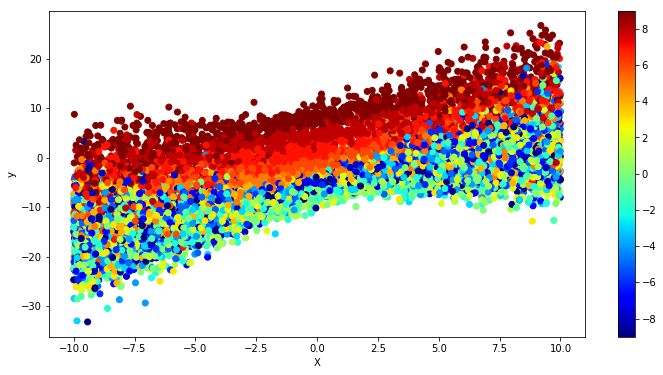

In [13]:
mask = torch.abs(mu_r) < 10
plt.figure(figsize=(12,6))
plt.scatter(x_r[:, mask], y[:, mask],
            c=mu_r[mask].reshape(-1,1).repeat(1, x_r.shape[0]).transpose(1,0), cmap=my_cmap)
plt.colorbar()
plt.xlabel("X");
plt.ylabel("y");

In [12]:
# plt.figure(figsize=(12,6))
# plt.pcolormesh(mu_r, x_r, y, cmap=my_cmap);
# plt.colorbar()
# plt.xlabel(r'$\mu$');
# plt.ylabel("X");

### 2d case for mu

In [6]:
import numpy as np
from itertools import product
from model import OptLoss

In [7]:
#mu = dist.Uniform(-10,10).sample([10000, 2])
x = np.linspace(-10, 10, 1000)
y = np.linspace(-10, 10, 1000)
mu = torch.tensor(np.array(list(product(x,y)))).float()

x_r = y_sampler.x_dist.sample(torch.Size([len(mu), 1000]))#.double()
y_sampler.make_condition_sample({'mu': mu, 'X': x_r})



y_mean = y_sampler.condition_sample().mean(dim=1)

# plt.figure(figsize=(12,6))
# plt.scatter(mu[:,0], mu[:, 1], c=y_mean, cmap=my_cmap)
# plt.colorbar()

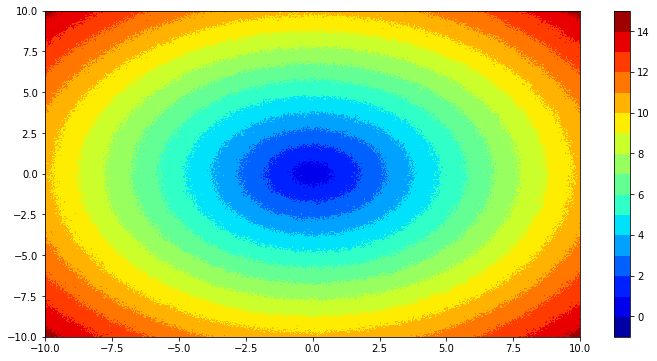

In [10]:
plt.figure(figsize=(12,6))
#plt.scatter(mu[:,0], mu[:, 1], c=y_mean, cmap=my_cmap)
plt.contourf(*np.meshgrid(x,y), y_mean.reshape(-1, 1000), cmap=my_cmap, levels=15)
plt.colorbar()

In [56]:
import numpy as np
mu = dist.Uniform(-10,10).sample([1000, 2])
x_r = y_sampler.x_dist.sample(torch.Size([len(mu), 10000]))#.double()
y_sampler.make_condition_sample({'mu': mu, 'X': x_r})
samples = y_sampler.condition_sample()
rs = OptLoss.R(samples, 5)

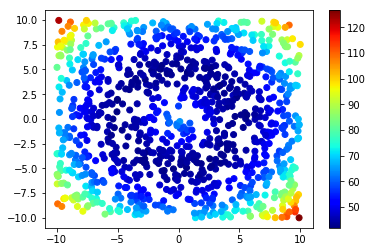

In [57]:
plt.scatter(mu[:,0], mu[:,1], c=rs,  cmap=my_cmap)
#plt.yscale("log")
plt.colorbar()

In [58]:
import numpy as np
mu = dist.Uniform(-10,10).sample([1000, 2])
x_r = y_sampler.x_dist.sample(torch.Size([len(mu), 10000]))#.double()
y_sampler.make_condition_sample({'mu': mu, 'X': x_r})
samples = y_sampler.condition_sample()
rs = OptLoss.SigmoidLoss(samples, 5, 10)

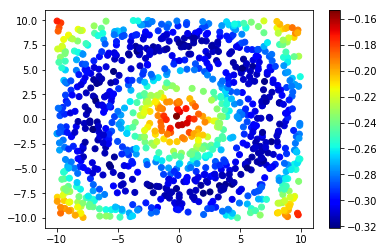

In [59]:
plt.scatter(mu[:,0], mu[:,1], c=rs,  cmap=my_cmap)
#plt.yscale("log")
plt.colorbar()

In [47]:
#mu = dist.Uniform(-10,10).sample([10000, 2])
x = np.linspace(-10, 10, 100)
y = np.linspace(-10, 10, 100)
mu = torch.tensor(np.array(list(product(x,y)))).float()

x_r = y_sampler.x_dist.sample(torch.Size([len(mu), 1000]))#.double()
y_sampler.make_condition_sample({'mu': mu, 'X': x_r})



y_mean = y_sampler.condition_sample()#.mean(dim=1)
rs = OptLoss.SigmoidLoss(y_mean, 5, 10)
# plt.figure(figsize=(12,6))
# plt.scatter(mu[:,0], mu[:, 1], c=y_mean, cmap=my_cmap)
# plt.colorbar()

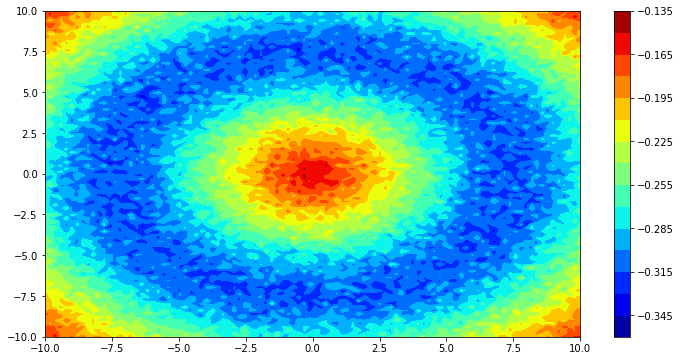

In [48]:
plt.figure(figsize=(12,6))
#plt.scatter(mu[:,0], mu[:, 1], c=y_mean, cmap=my_cmap)
plt.contourf(*np.meshgrid(x,y), rs.reshape(-1, 100), cmap=my_cmap, levels=15)
plt.colorbar()

## Statistic of interest

$$r = \frac{1}{N} \sum\limits_{i=0}^{N} || y_i - Y ||_2^2$$

In [4]:
from model import OptLoss

## Approaches to solve the problem

### First one

  1. Make approximation of this model:

  $$p(y | \mu)$$

  With GANs or some other techniques.
  

  2. Sample $\{ y_i \}_{i=0}^{B} \sim p(y | \mu)$
  
  
  3. Calc $r = R(\{ y_i \}_{i=0}^{B})$
  
  
  4. Find $\frac{\partial r}{\partial \mu}$
  
### Second one


  1. Make approximation of this model:

  $$p(r | \mu)$$
  
  
  2. Sample $r \sim p(r | \mu)$
  
  
  3. Find $\frac{\partial r}{\partial \mu}$

In [6]:
import numpy as np
mu = torch.arange(-10,10,0.5).reshape(-1,1).float()
x_r = y_sampler.x_dist.sample(torch.Size([len(mu), 10000]))
y_sampler.make_condition_sample({'mu': mu, 'X': x_r})
samples = y_sampler.condition_sample()
rs = OptLoss.R(samples, -5)

In [ ]:
plt.scatter(mu, rs)
plt.yscale("log")

In [29]:
mu[np.argmin(rs)], torch.min(rs)

(tensor([3.5000]), tensor(42.6778))

### Sigmoid loss

Text(0.5, 1.0, 'loss')

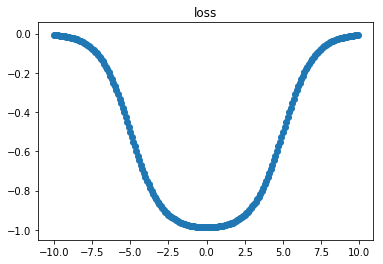

In [52]:
plt.scatter(np.arange(-10, 10, 0.1), OptLoss.SigmoidLoss(torch.tensor(np.arange(-10, 10, 0.1)).reshape(-1,1), -5, 5))
plt.title("loss")

In [7]:
import numpy as np
mu = torch.linspace(-25, 0, 1000).reshape(-1,1).float()
x_r = y_sampler.x_dist.sample(torch.Size([len(mu), 10000]))
y_sampler.make_condition_sample({'mu': mu, 'X': x_r})
samples = y_sampler.condition_sample()
rs = OptLoss.SigmoidLoss(samples, -5, 5)

Text(0.5, 1.0, 'Average over X loss value')

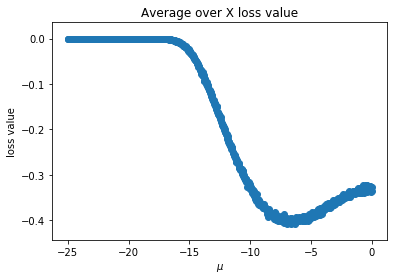

In [17]:
plt.scatter(mu, rs)
plt.xlabel("$\mu$")
plt.ylabel("loss value")
plt.title("Average over X loss value")
#plt.yscale("log")
#plt.xlim(-8,-2)

In [184]:
mu[np.argmin(rs)], torch.min(rs)

(tensor([-6.1812]), tensor(-0.4076))

## tests

In [59]:
from utils import generate_data

In [63]:
device = torch.device("cuda", 0)
d, i = generate_data(y_sampler, device, 100, mu_dim=2)
i.shape

torch.Size([100, 3])

In [65]:
from utils import DistPlotter, sample_noise
import torch.nn as nn
import torch.nn.functional as F

class Generator(nn.Module):
    def __init__(self, noise_dim, out_dim, hidden_dim=100, input_param=2):
        super(Generator, self).__init__()
        
        self.fc1 = nn.Linear(noise_dim + input_param, hidden_dim)
        nn.init.xavier_normal_(self.fc1.weight)
        nn.init.constant_(self.fc1.bias, 0.0)
        
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        nn.init.xavier_normal_(self.fc2.weight)
        nn.init.constant_(self.fc2.bias, 0.0)
        
        self.fc3 = nn.Linear(hidden_dim, out_dim)
        nn.init.xavier_normal_(self.fc3.weight)
        nn.init.constant_(self.fc3.bias, 0.0)

    def forward(self, z, params):
        """
            Generator takes a vector of noise and produces sample
        """
        
        #z = torch.cat([z, params.repeat(z.shape[0], 1)], dim=1)
        z = torch.cat([z, params], dim=1)
        h1 = torch.tanh(self.fc1(z))
        h2 = F.leaky_relu(self.fc2(h1))
        y_gen = self.fc3(h2)
        return y_gen

# Optimisation with true model

In [16]:
from model import YModel

In [17]:
y_sampler = YModel(init_mu=torch.tensor([0.]))


In [18]:
import numpy as np

In [18]:
mu_for_grad = torch.tensor([-1.]).reshape(1,-1)
mu_for_grad = mu_for_grad.repeat(1000, 1)
mu_for_grad.requires_grad=True

In [19]:
%%time
n_iter = 30000
losses = []
m_vals = []
lr = 10.
for _iter in range(n_iter):
    X = y_sampler.x_dist.sample([1000,1])    
    y_sampler.make_condition_sample({"mu": mu_for_grad, "X":X})
    samples = y_sampler.condition_sample()
    loss = OptLoss.SigmoidLoss(samples, -5, 5).mean()
    losses.append(loss.item())
    loss.backward()
    with torch.no_grad():
        mu_for_grad -= lr * mu_for_grad.grad.mean(dim=0, keepdim=True)
        mu_for_grad.grad.zero_()
    m_vals.append(mu_for_grad[0,0].item())
m_vals = np.array(m_vals)    

CPU times: user 2min 53s, sys: 7min 45s, total: 10min 38s
Wall time: 1min 6s


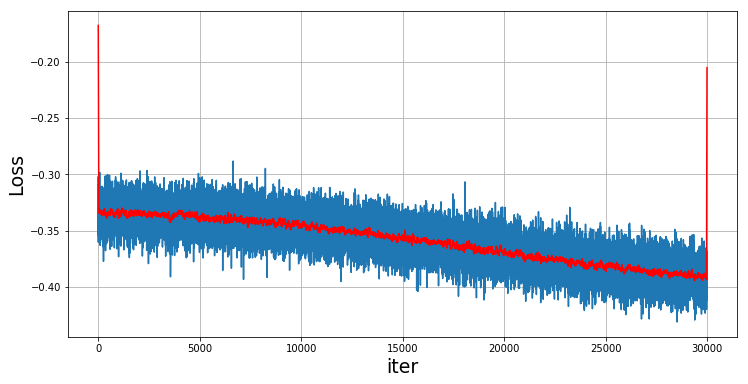

In [20]:
def movingaverage(interval, window_size):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')    


plt.figure(figsize=(12,6))
plt.plot(losses);
plt.grid()
plt.ylabel("Loss", fontsize=19)
plt.xlabel("iter", fontsize=19)
plt.plot((movingaverage(losses, 50)), c='r')

Text(0.5, 0, 'iter')

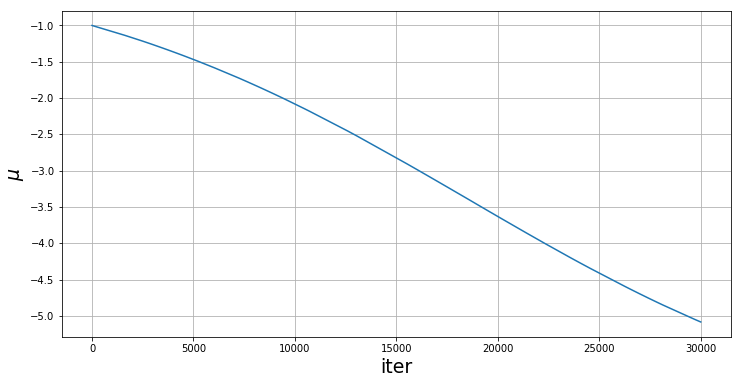

In [21]:
plt.figure(figsize=(12,6))
plt.plot(m_vals);
plt.grid()
plt.ylabel("$\mu$", fontsize=19)
plt.xlabel("iter", fontsize=19)

In [23]:
def find_mu(init_mu, n_iter=100000):
    mu_for_grad = torch.tensor([float(init_mu)]).reshape(1,-1)
    mu_for_grad = mu_for_grad.repeat(1000, 1)
    mu_for_grad.requires_grad=True    
#     losses = []
#     m_vals = []
    lr = 10.
    for _iter in range(n_iter):
        X = y_sampler.x_dist.sample([1000,1])    
        y_sampler.make_condition_sample({"mu": mu_for_grad, "X":X})
        samples = y_sampler.condition_sample()
        loss = OptLoss.SigmoidLoss(samples, -5, 5).mean()
        #losses.append(loss.item())
        loss.backward()
        with torch.no_grad():
            mu_for_grad -= lr * mu_for_grad.grad.mean(dim=0, keepdim=True)
            mu_for_grad.grad.zero_()
        #m_vals.append(mu_for_grad[0,0].item())
    #m_vals = np.array(m_vals)
    return mu_for_grad[0].item()

In [ ]:
opt_mu = []
for mu in np.arange(-15, 16, 1):
    opt_mu.append(find_mu(mu))

In [ ]:
plt.figure(figsize=(12,6))
plt.scatter(np.arange(-15,1,1), opt_mu)
plt.grid()
plt.ylabel("$\mu_{final}$", fontsize=19)
plt.xlabel("$\mu_{initial}$", fontsize=19)
plt.savefig("./gan/plots/1d_true_grad.pdf", bbox_inches='tight')

# 2d opt paths

In [75]:
def find_mu(init_mu, n_iter=100000, average_size=1000):
    mu_optim = torch.tensor(init_mu).reshape(1,-1)
    mu_optim = mu_optim.repeat([average_size, 1]).to(device)
    mu_optim.requires_grad=True
    #losses = []
    m_vals = []
    lr = 50.
    for _iter in range(n_iter):
        X = y_sampler.x_dist.sample([average_size, 1]).to(device)
        y_sampler.make_condition_sample({"mu": mu_optim, "X":X})
        # Do an update
        samples = y_sampler.condition_sample()
        loss = OptLoss.SigmoidLoss(samples, 5, 10).mean()
        #losses.append(loss.item())
        loss.backward()       
        with torch.no_grad():
            mu_optim -= lr * mu_optim.grad.mean(dim=0, keepdim=True)
            mu_optim.grad.zero_()
        m_vals.append(mu_optim[0].detach().cpu().numpy().copy())
    return m_vals

In [78]:
opt_mu = []
for mu in [[0.,0.], [0., 2.], [0., -2.], [2., 0.], [10., 10.], [-10., 0.], [0., 7.], [0., 10.]]:
    opt_mu.append(find_mu(mu, n_iter=10000))

In [79]:
vals = np.linspace(0,1,256)
np.random.shuffle(vals)
cmap = plt.cm.colors.ListedColormap(plt.cm.Dark2(vals))

In [81]:
%%time
x = np.linspace(-10, 10, 1000)
y = np.linspace(-10, 10, 1000)
mu = torch.tensor(np.array(list(product(x,y)))).float()

x_r = y_sampler.x_dist.sample(torch.Size([len(mu), 1000]))#.double()
y_sampler.make_condition_sample({'mu': mu, 'X': x_r})



y_mean = y_sampler.condition_sample()
rs = OptLoss.SigmoidLoss(y_mean, 5, 10)

CPU times: user 57.1 s, sys: 1min 11s, total: 2min 8s
Wall time: 1min 34s


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

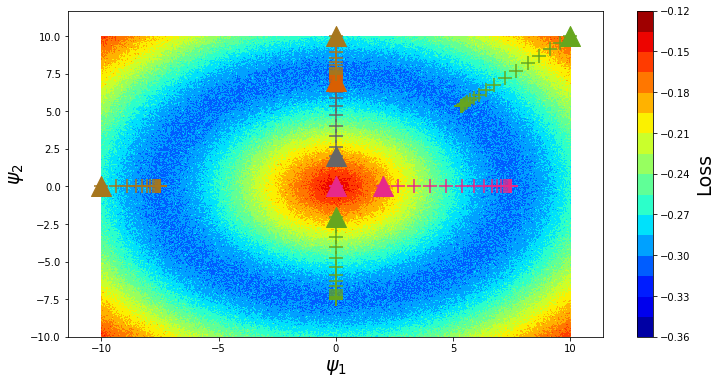

In [89]:
plt.figure(figsize=(12,6))
# mu = dist.Uniform(-10,10).sample([10000, 2])
# x_r = y_sampler.x_dist.sample(torch.Size([len(mu), 1000]))
# y_sampler.make_condition_sample({'mu': mu, 'X': x_r})
# samples = y_sampler.condition_sample()
# rs = OptLoss.SigmoidLoss(samples, 5, 10)
# plt.scatter(mu[:,0], mu[:,1], c=rs,  cmap=my_cmap)

plt.contourf(*np.meshgrid(x,y), rs.reshape(-1, 1000).numpy().T, cmap=my_cmap, levels=15)
cbar = plt.colorbar()
plt.xlabel(f"$\psi_1$", fontsize=19)
plt.ylabel(f"$\psi_2$", fontsize=19)
cbar.set_label('Loss', rotation=90, fontsize=19)


for index, mu_path in enumerate(opt_mu):        
    mus = np.array(mu_path)
    if index == 0:
        mus = np.zeros_like(mus)
    plt.scatter(mus[0, 0], mus[0, 1], c=cmap(index), marker='^', s=400)
    plt.scatter(mus[::500, 0], mus[::500, 1], c=cmap(index), marker='+', s=200)
    plt.grid()
    plt.grid()
plt.savefig("./gan/plots/true_paths.png")